导入 Python 库&模块并配置运行信息

In [1]:
# 导入相关依赖库
import os
from matplotlib import pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import (
    ModelCheckpoint,
    CheckpointConfig,
    LossMonitor,
    TimeMonitor,
)

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

数据读取

In [2]:
DATA_DIR_TRAIN = "MNIST/train"  # 训练集信息
DATA_DIR_TEST = "MNIST/test"  # 测试集信息
# 读取数据
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST)
# 显示数据集的相关特性
print("训练数据集数量：", ds_train.get_dataset_size())
print("测试数据集数量：", ds_test.get_dataset_size())
image = ds_train.create_dict_iterator().__next__()
print("图像长/宽/通道数：", image["image"].shape)
print("一张图像的标签样式：", image["label"].shape)

训练数据集数量： 60000
测试数据集数量： 10000
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： ()


数据处理

In [3]:
def create_dataset(
    training=True,
    batch_size=128,
    resize=(28, 28),
    rescale=1 / 255,
    shift=0,
    buffer_size=64,
):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # 定义 Map 操作尺寸缩放，归一化和通道变换
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    # 对数据集进行 Map 操作
    ds = ds.map(input_columns="image", operations=[rescale_op, resize_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # 设定打乱操作参数和 batchsize 大小
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds

样本可视化

[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:35.503.271 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:35.503.944 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:35.504.454 [mindspore/dataset/core/validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:35.504.967 [mindspore/dataset

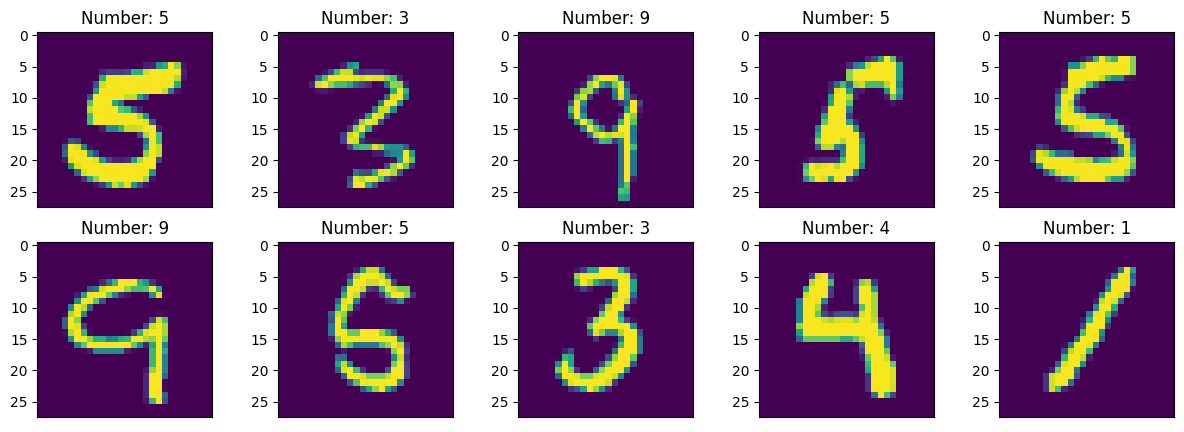

In [4]:
# 显示前10张图片以及对应标签，检查图片是否是正确的数据集
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
plt.figure(figsize=(15, 5))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title("Number: %s" % labels[i])
    plt.xticks([])
plt.show()

定义网络

In [5]:
# 创建模型。模型包括3个全连接层，最后输出层使用softmax进行多分类，并分成 (0-9) 10类
class ForwardNN(nn.Cell):
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation="relu")
        self.fc2 = nn.Dense(512, 128, activation="relu")
        self.fc3 = nn.Dense(128, 10, activation=None)

    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output

定义损失函数及优化器

In [6]:
# 创建网络，损失函数，评估指标，优化器，设定相关超参数
lr = 0.001
num_epochs = 10
momentum = 0.9

net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
metrics = {"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr)

开始训练

In [7]:
# 编译模型
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(
    prefix="checkpoint_net", directory="./ckpt", config=config_ck
)
# 生成数据集
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)
# 训练模型
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(
    num_epochs,
    ds_train,
    callbacks=[time_cb, loss_cb, ckpoint_cb],
    dataset_sink_mode=False,
)

[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:36.131.462 [mindspore/dataset/core/validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:36.132.061 [mindspore/dataset/core/validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:36.132.551 [mindspore/dataset/core/validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(3695:140026106181440,MainProcess):2023-07-12-19:25:36.133.119 [mindspore/dataset

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.1444977968931198
Train epoch time: 26178.498 ms, per step time: 13.962 ms
epoch: 2 step: 1875, loss is 0.3025037944316864
Train epoch time: 25802.472 ms, per step time: 13.761 ms
epoch: 3 step: 1875, loss is 0.02648531273007393
Train epoch time: 25499.442 ms, per step time: 13.600 ms
epoch: 4 step: 1875, loss is 0.0033615503925830126
Train epoch time: 25696.370 ms, per step time: 13.705 ms
epoch: 5 step: 1875, loss is 0.062121350318193436
Train epoch time: 24797.239 ms, per step time: 13.225 ms
epoch: 6 step: 1875, loss is 0.0014841336524114013
Train epoch time: 24707.084 ms, per step time: 13.177 ms
epoch: 7 step: 1875, loss is 0.0007281875587068498
Train epoch time: 24600.437 ms, per step time: 13.120 ms
epoch: 8 step: 1875, loss is 0.0002206545468652621
Train epoch time: 25496.630 ms, per step time: 13.598 ms
epoch: 9 step: 1875, loss is 0.010729510337114334
Train epoch time: 24699.005 ms, per step time: 

模型评估

In [8]:
# 使用测试集评估模型，打印总体准确率
metrics = model.eval(ds_eval)
print(metrics)

{'Accuracy': 0.9791666666666666}
